## **Handmade Products Dataset**

## **LSTM**

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import pandas as pd
import json

# Load metadata dataset with streaming
metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023",
                                "raw_meta_Handmade_Products",
                                split="full", streaming=True,
                                trust_remote_code=True)

# Function to preprocess metadata
def process_metadata(meta):
    try:
        details = json.loads(meta.get("details", "{}"))  # Convert details from JSON string if available
        first_available_date = details.get("Date First Available", None)  # Extract date if present
        return {
            "main_category": meta.get("main_category", None),
            "title": meta.get("title", None),
            "average_rating": meta.get("average_rating", None),
            "rating_number": meta.get("rating_number", None),
            "price": meta.get("price", None),
            "store": meta.get("store", None),
            "parent_asin": meta.get("parent_asin", None),
            "date_first_available": first_available_date  # Extracted from 'details' JSON
        }
    except Exception as e:
        print(f"Error processing metadata: {e}")
        return None

# Process and filter metadata
data = [process_metadata(meta) for meta in metadata_dataset if process_metadata(meta)]

# Convert to DataFrame
df_meta = pd.DataFrame(data)

# Save as CSV
df_meta.to_csv("amazon_metadata_Handmade_Products.csv", index=False)

print("Metadata extracted and saved successfully!")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

Metadata extracted and saved successfully!


In [ ]:
!pip install pandas numpy matplotlib seaborn nltk textblob wordcloud scikit-learn

## **Loading the Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
meta_data = pd.read_csv("/content/amazon_metadata_Handmade_Products.csv")
reviews = pd.read_csv("/content/amazon_reviews_Handmade_Products.csv")

# Display first few rows
print("Metadata Dataset:")
display(meta_data.head())

print("\nReviews Dataset:")
display(reviews.head())

Metadata Dataset:


,main_category,title,average_rating,rating_number,price,store,parent_asin,date_first_available
0,Handmade,Daisy Keychain Wristlet Gray Fabric Key fob La...,4.5,12,NaN,Generic,B07NTK7T5P,"September 11, 2018"
1,Handmade,Anemone Jewelry Beauteous November Birthstone ...,4.1,10,69.00,Anemone Jewelry,B0751M85FV,"July 30, 2017"
2,Handmade,Silver Triangle Earrings with Chevron Pattern,5.0,1,NaN,Zoë Noelle Designs,B01HYNE114,"July 4, 2016"
3,Handmade,"Las Vegas Subway Sign Print - Caesar's, Freemo...",1.0,1,19.95,Generic,B07TKZF3Z1,"June 14, 2018"
4,Handmade,Round Cut Cubic Zirconia Stud Earrings Fashion...,4.2,2,14.99,VDKIDKT,B0BKBJT5MM,"October 25, 2022"



Reviews Dataset:


,rating,title,text,helpful_vote,parent_asin,verified_purchase,review_date
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...,1,B08GPJ1MSN,True,2021-05-21
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,0,B084TWHS7W,True,2020-04-24
2,5.0,Great,As pictured. Used a frame from the dollar stor...,0,B07V3NRQC4,True,2020-06-06
3,5.0,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ...",2,B071ZMDK26,True,2019-06-02
4,5.0,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...,1,B01MPVZ4YP,True,2019-01-08


## **Data Preprocessing**

In [ ]:
# Convert review_date with error handling
reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)

# Convert date_first_available with error handling
meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)

# Identify rows with conversion issues
print("Invalid dates in reviews:", reviews["review_date"].isna().sum())
print("Invalid dates in meta_data:", meta_data["date_first_available"].isna().sum())

# Optionally drop rows with NaT values after conversion
reviews.dropna(subset=["review_date"], inplace=True)
meta_data.dropna(subset=["date_first_available"], inplace=True)

# Merge datasets
merged_df = reviews.merge(meta_data, on="parent_asin", how="left")

print("Merged Data Preview:")
display(merged_df.head())


<ipython-input-4-6419238e334a>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)
<ipython-input-4-6419238e334a>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)


Invalid dates in reviews: 0
Invalid dates in meta_data: 5941
Merged Data Preview:


,rating,title_x,text,helpful_vote,parent_asin,verified_purchase,review_date,main_category,title_y,average_rating,rating_number,price,store,date_first_available
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...,1,B08GPJ1MSN,True,2021-05-21,Handmade,Orgone Chakra Necklace With Adjustable Cord - ...,4.3,1194.0,17.99,Crystal Vibe,2020-09-09
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,0,B084TWHS7W,True,2020-04-24,Handmade,Yellow Floral Green Gingham Spring Wreath Bow,5.0,4.0,13.49,Package Perfect Bows,2015-09-26
2,5.0,Great,As pictured. Used a frame from the dollar stor...,0,B07V3NRQC4,True,2020-06-06,Handmade,Live Simply Enjoy the Ride Vintage Bicycle Ins...,4.3,21.0,14.95,WESTBROOK DESIGN STUDIO,2019-07-11
3,5.0,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ...",2,B071ZMDK26,True,2019-06-02,Handmade,"Sterling Silver Moon Phase Charm Necklace, 18""",4.7,1214.0,24.00,KEVIN N ANNA,2017-04-22
4,5.0,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...,1,B01MPVZ4YP,True,2019-01-08,Handmade,FLOWER DANCE Fragrance Oil 1oz Beaumondes Perf...,4.2,73.0,NaN,Beaumondes,2016-10-23


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
# Ensure missing text is filled
reviews["text"] = reviews["text"].fillna("")

# Convert rating into sentiment labels (3+ = positive, else negative)
reviews["label"] = reviews["rating"].apply(lambda x: 1 if x >= 3 else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(reviews["text"], reviews["label"], test_size=0.2, random_state=42)

## **Tokenization**

In [ ]:
#%%
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 200  # Max length of sequences

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
#%%
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
#%%
# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")
#%%
# Convert labels to NumPy arrays
y_train, y_test = np.array(y_train), np.array(y_test)
#%%
# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## **Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

# 🔹 🔟 Train Model
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test),
                    epochs=5, batch_size=32, callbacks=[early_stop])

Epoch 1/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 324s 19ms/step - accuracy: 0.9055 - loss: 0.3177 - val_accuracy: 0.9056 - val_loss: 0.3127
Epoch 2/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 321s 19ms/step - accuracy: 0.9066 - loss: 0.3108 - val_accuracy: 0.9056 - val_loss: 0.3168
Epoch 3/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 321s 19ms/step - accuracy: 0.9065 - loss: 0.3109 - val_accuracy: 0.9056 - val_loss: 0.3163


In [ ]:
# 🔹 1️⃣1️⃣ Evaluate Model
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")

4152/4152 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.9044 - loss: 0.3154
Test Accuracy: 0.9056


## **Model Evaluation**

In [ ]:
from sklearn.metrics import classification_report


# 🔹 1️⃣2️⃣ Generate Predictions for Classification Report
y_pred_prob = model.predict(X_test_pad)  # Get probability scores
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels (0 or 1)

# 🔹 1️⃣3️⃣ Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

4152/4152 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step

Classification Report:
               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     12539
    Positive       0.91      1.00      0.95    120294

    accuracy                           0.91    132833
   macro avg       0.45      0.50      0.48    132833
weighted avg       0.82      0.91      0.86    132833



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 🔹 1️⃣1️⃣ Save the trained model
model.save("sentiment_lstm1.0.h5")
print("Model saved successfully!")

Model saved successfully!


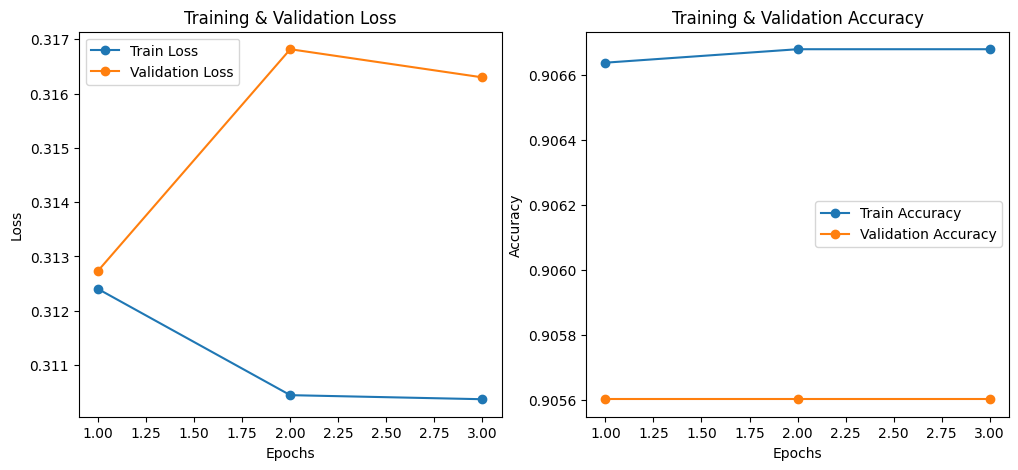

In [ ]:
import matplotlib.pyplot as plt

# Retrieve metrics from the training history
epochs_range = range(1, len(history.history["loss"]) + 1)
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss", marker='o')
plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


## **DistilBERT**

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## **Data Preprocessing**

In [ ]:
# 🔹 1️⃣ Fill missing text data
reviews["text"] = reviews["text"].fillna("")

# 🔹 2️⃣ Convert ratings into sentiment labels (3+ = positive, else negative)
reviews["label"] = reviews["rating"].apply(lambda x: 1 if x >= 3 else 0)

# 🔹 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(reviews["text"], reviews["label"], test_size=0.2, random_state=42)

# 🔹 4️⃣ Load DistilBERT Tokenizer (Lighter BERT)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
max_len = 128
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=max_len, return_tensors="pt")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=max_len, return_tensors="pt")

In [ ]:
# 🔹 6️⃣ Convert to PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())

In [ ]:
# 🔹 7️⃣ Optimized DataLoader
batch_size = 32  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

In [ ]:
# 🔹 8️⃣ Load DistilBERT Model (Lighter Version)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 🔹 9️⃣ Optimized Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.98), weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:
# 🔹 🔟 Enable Gradient Accumulation (for memory efficiency)
epochs = 3
scaler = torch.cuda.amp.GradScaler()
accumulation_steps = 4  # Accumulate gradients every 4 batches

<ipython-input-30-a99a1a73c7d3>:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## **Training**

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.cuda.amp.autocast():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps  # Scale loss

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

<ipython-input-31-322ff444f21c>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1, Loss: 0.0974
Epoch 2, Loss: 0.0790
Epoch 3, Loss: 0.0665


In [ ]:
# 🔹 1️⃣1️⃣ Evaluation Loop
model.eval()
preds, true_labels = [], []

In [ ]:
# 🔹 1️⃣3️⃣ Save Model Properly
model_save_path = "distilbert_sentiment1"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model and tokenizer saved successfully at '{model_save_path}'")

Model and tokenizer saved successfully at 'distilbert_sentiment1'


In [ ]:
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

## **Model Evaluation**

In [ ]:
print("\nClassification Report:\n", classification_report(true_labels, preds, target_names=["Negative", "Positive"]))



Classification Report:
               precision    recall  f1-score   support

    Negative       0.81      0.80      0.81     12539
    Positive       0.98      0.98      0.98    120294

    accuracy                           0.96    132833
   macro avg       0.90      0.89      0.89    132833
weighted avg       0.96      0.96      0.96    132833



In [ ]:
# Calculate Accuracy
correct = sum(1 for x, y in zip(preds, true_labels) if x == y)
accuracy = correct / len(true_labels)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9636


## **TextCNN**

## **Loading of Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
# 🔹 1️⃣ Load & Preprocess Data
reviews["text"] = reviews["text"].fillna("")  # Fill missing values
reviews["label"] = reviews["rating"].apply(lambda x: 1 if x >= 3 else 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews["text"], reviews["label"], test_size=0.2, random_state=42)


## **Tokenization**

In [ ]:
# 🔹 2️⃣ Tokenization & Padding
max_words = 10000   # Vocabulary size
max_len = 200       # Max sequence length

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

In [ ]:
y_train, y_test = np.array(y_train), np.array(y_test)

In [ ]:
# 🔹 3️⃣ Build TextCNN Model
def build_textcnn(vocab_size, embedding_dim=128, input_length=200):
    inputs = Input(shape=(input_length,))
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length)(inputs)

    conv1 = Conv1D(filters=128, kernel_size=3, activation="relu")(embedding)
    pool1 = GlobalMaxPooling1D()(conv1)

    conv2 = Conv1D(filters=128, kernel_size=4, activation="relu")(embedding)
    pool2 = GlobalMaxPooling1D()(conv2)

    conv3 = Conv1D(filters=128, kernel_size=5, activation="relu")(embedding)
    pool3 = GlobalMaxPooling1D()(conv3)

    merged = tf.keras.layers.concatenate([pool1, pool2, pool3])
    dropout = Dropout(0.5)(merged)
    dense = Dense(32, activation="relu")(dropout)
    outputs = Dense(1, activation="sigmoid")(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [ ]:
model = build_textcnn(vocab_size=max_words)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## **Training**

In [ ]:
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=32)


Epoch 1/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 127s 7ms/step - accuracy: 0.9446 - loss: 0.1366 - val_accuracy: 0.9570 - val_loss: 0.1045
Epoch 2/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 123s 6ms/step - accuracy: 0.9595 - loss: 0.0978 - val_accuracy: 0.9578 - val_loss: 0.1014
Epoch 3/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 106s 6ms/step - accuracy: 0.9627 - loss: 0.0897 - val_accuracy: 0.9579 - val_loss: 0.1047
Epoch 4/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 106s 6ms/step - accuracy: 0.9656 - loss: 0.0837 - val_accuracy: 0.9584 - val_loss: 0.1073
Epoch 5/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.9687 - loss: 0.0765 - val_accuracy: 0.9583 - val_loss: 0.1130


## **Model Evaluation**

In [ ]:
# 🔹 5️⃣ Evaluate Model
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

4152/4152 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step

Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.75      0.77     12539
    Positive       0.97      0.98      0.98    120294

    accuracy                           0.96    132833
   macro avg       0.88      0.87      0.87    132833
weighted avg       0.96      0.96      0.96    132833



In [ ]:
model.save("textcnn_sentiment.h5")
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(tokenizer_json)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [ ]:
# 🔹 Calculate Accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9583


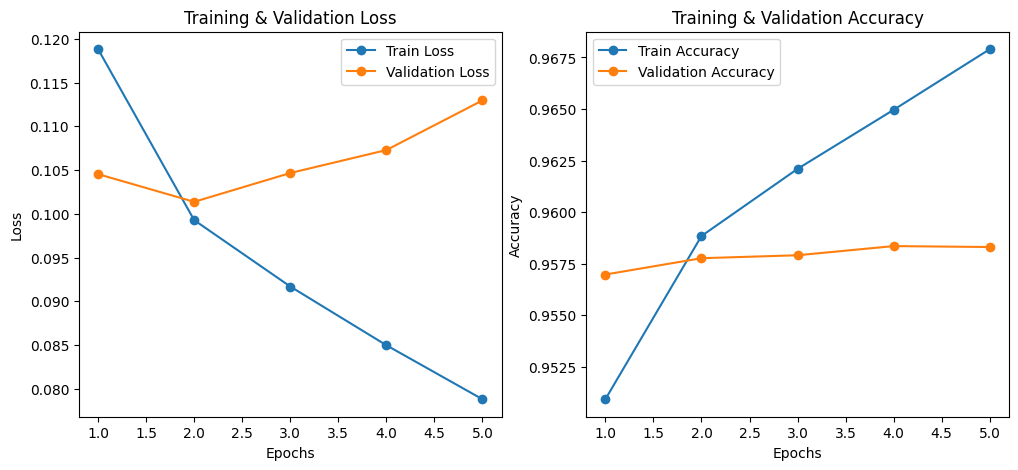

In [ ]:
import matplotlib.pyplot as plt

# Retrieve metrics from the training history
epochs_range = range(1, len(history.history["loss"]) + 1)
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss", marker='o')
plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


## **CNN + BiLSTM**

## **Loading of Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# 🔹 Load and preprocess dataset
reviews["text"] = reviews["text"].fillna("")
reviews["label"] = reviews["rating"].apply(lambda x: 1 if x >= 3 else 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reviews["text"], reviews["label"], test_size=0.2, random_state=42)

## **Tokenization**

In [ ]:
# 🔹 Tokenization
max_words = 20000  # Vocabulary size
max_len = 200  # Max sequence length

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# 🔹 Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post", truncating="post")

In [ ]:
y_train, y_test = np.array(y_train), np.array(y_test)


In [ ]:
# 🔹 Build Hybrid CNN + BiLSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(64, kernel_size=5, activation="relu", padding="same"),
    Bidirectional(LSTM(64, return_sequences=True)),  # Return sequences to maintain 3D input
    GlobalMaxPooling1D(),  # Now it can safely reduce dimensions
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


## **Training**

In [ ]:
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=5, batch_size=32)


Epoch 1/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 398s 23ms/step - accuracy: 0.9463 - loss: 0.1333 - val_accuracy: 0.9572 - val_loss: 0.1053
Epoch 2/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 417s 22ms/step - accuracy: 0.9620 - loss: 0.0923 - val_accuracy: 0.9582 - val_loss: 0.0996
Epoch 3/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 385s 22ms/step - accuracy: 0.9663 - loss: 0.0829 - val_accuracy: 0.9583 - val_loss: 0.0995
Epoch 4/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 394s 23ms/step - accuracy: 0.9704 - loss: 0.0743 - val_accuracy: 0.9579 - val_loss: 0.1138
Epoch 5/5
16605/16605 ━━━━━━━━━━━━━━━━━━━━ 378s 23ms/step - accuracy: 0.9735 - loss: 0.0666 - val_accuracy: 0.9578 - val_loss: 0.1094


## **Model Evaluation**

In [ ]:
# 🔹 Evaluate Model
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

4152/4152 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
Test Accuracy: 0.9578


In [ ]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))



Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.75      0.77     12539
    Positive       0.97      0.98      0.98    120294

    accuracy                           0.96    132833
   macro avg       0.88      0.87      0.87    132833
weighted avg       0.96      0.96      0.96    132833



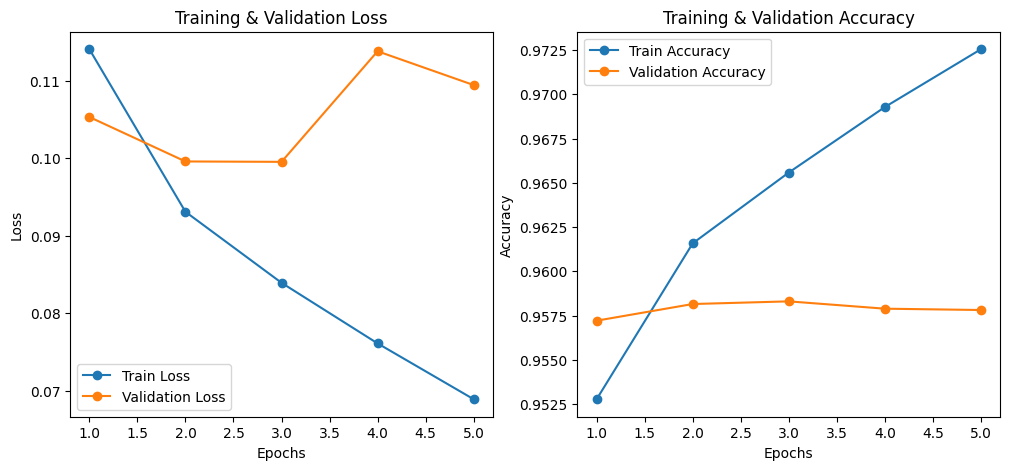

In [ ]:
import matplotlib.pyplot as plt

# Retrieve metrics from the training history
epochs_range = range(1, len(history.history["loss"]) + 1)
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Train Loss", marker='o')
plt.plot(epochs_range, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_acc, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()


## **Model Accuracy Comparison**

<ipython-input-1-f4985911003e>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="Blues_r")


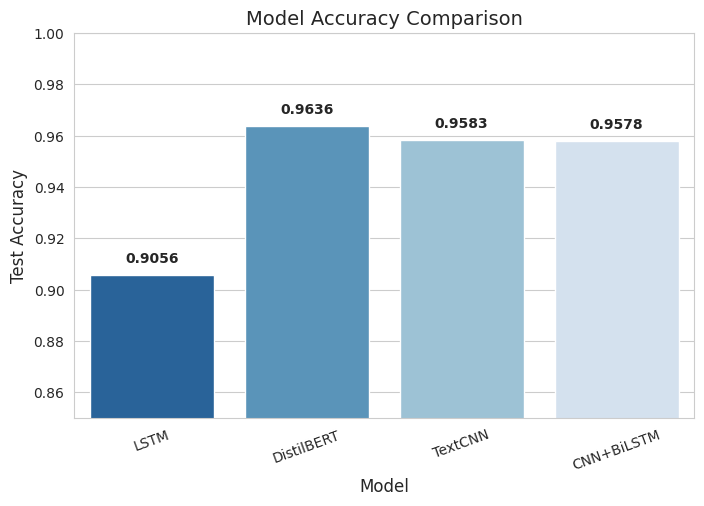

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy values for each model
models = ["LSTM", "DistilBERT", "TextCNN", "CNN+BiLSTM"]
accuracies = [0.9056, 0.9636, 0.9583, 0.9578]

# Set Seaborn style
sns.set_style("whitegrid")

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette="Blues_r")

# Add labels and title
plt.ylim(0.85, 1.0)  # Adjust y-axis for better visualization
plt.xlabel("Model", fontsize=12)
plt.ylabel("Test Accuracy", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xticks(rotation=20)

# Annotate bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.005, f"{acc:.4f}", ha="center", fontsize=10, fontweight="bold")

# Show plot
plt.show()


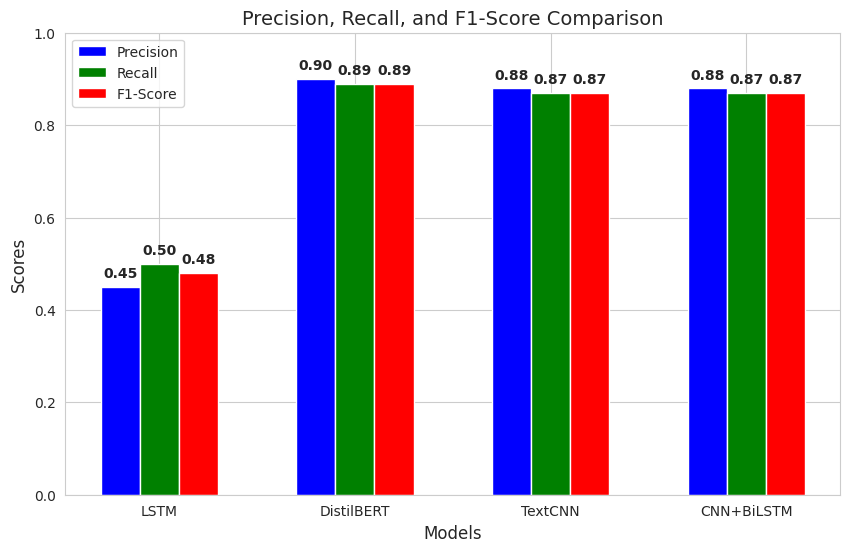

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Model Names
models = ["LSTM", "DistilBERT", "TextCNN", "CNN+BiLSTM"]

# Precision, Recall, and F1-Score values (Macro Avg)
precision = [0.45, 0.90, 0.88, 0.88]
recall = [0.50, 0.89, 0.87, 0.87]
f1_score = [0.48, 0.89, 0.87, 0.87]

# Bar width
bar_width = 0.2

# X-axis positions
x = np.arange(len(models))

# Set Seaborn style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(x - bar_width, precision, width=bar_width, label="Precision", color="blue")
plt.bar(x, recall, width=bar_width, label="Recall", color="green")
plt.bar(x + bar_width, f1_score, width=bar_width, label="F1-Score", color="red")

# Labels and Title
plt.xlabel("Models", fontsize=12)
plt.ylabel("Scores", fontsize=12)
plt.title("Precision, Recall, and F1-Score Comparison", fontsize=14)
plt.xticks(ticks=x, labels=models)
plt.ylim(0, 1.0)

# Show legend
plt.legend()

# Annotate values on bars
for i in range(len(models)):
    plt.text(i - bar_width, precision[i] + 0.02, f"{precision[i]:.2f}", ha="center", fontsize=10, fontweight="bold")
    plt.text(i, recall[i] + 0.02, f"{recall[i]:.2f}", ha="center", fontsize=10, fontweight="bold")
    plt.text(i + bar_width, f1_score[i] + 0.02, f"{f1_score[i]:.2f}", ha="center", fontsize=10, fontweight="bold")

# Show the plot
plt.show()


## **Exploratory Data Analysis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
meta_data = pd.read_csv("/content/amazon_metadata_Handmade_Products.csv")
reviews = pd.read_csv("/content/amazon_reviews_Handmade_Products.csv")

# Display first few rows
print("Metadata Dataset:")
display(meta_data.head())

print("\nReviews Dataset:")
display(reviews.head())


Metadata Dataset:


,main_category,title,average_rating,rating_number,price,store,parent_asin,date_first_available
0,Handmade,Daisy Keychain Wristlet Gray Fabric Key fob La...,4.5,12,NaN,Generic,B07NTK7T5P,"September 11, 2018"
1,Handmade,Anemone Jewelry Beauteous November Birthstone ...,4.1,10,69.00,Anemone Jewelry,B0751M85FV,"July 30, 2017"
2,Handmade,Silver Triangle Earrings with Chevron Pattern,5.0,1,NaN,Zoë Noelle Designs,B01HYNE114,"July 4, 2016"
3,Handmade,"Las Vegas Subway Sign Print - Caesar's, Freemo...",1.0,1,19.95,Generic,B07TKZF3Z1,"June 14, 2018"
4,Handmade,Round Cut Cubic Zirconia Stud Earrings Fashion...,4.2,2,14.99,VDKIDKT,B0BKBJT5MM,"October 25, 2022"



Reviews Dataset:


,rating,title,text,helpful_vote,parent_asin,verified_purchase,review_date
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...,1,B08GPJ1MSN,True,2021-05-21
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,0,B084TWHS7W,True,2020-04-24
2,5.0,Great,As pictured. Used a frame from the dollar stor...,0,B07V3NRQC4,True,2020-06-06
3,5.0,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ...",2,B071ZMDK26,True,2019-06-02
4,5.0,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...,1,B01MPVZ4YP,True,2019-01-08


## **Data Preprocessing**

In [ ]:
# Convert review_date with error handling
reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)

# Convert date_first_available with error handling
meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)

# Identify rows with conversion issues
print("Invalid dates in reviews:", reviews["review_date"].isna().sum())
print("Invalid dates in meta_data:", meta_data["date_first_available"].isna().sum())

# Optionally drop rows with NaT values after conversion
reviews.dropna(subset=["review_date"], inplace=True)
meta_data.dropna(subset=["date_first_available"], inplace=True)

# Merge datasets
merged_df = reviews.merge(meta_data, on="parent_asin", how="left")

print("Merged Data Preview:")
display(merged_df.head())


<ipython-input-5-6419238e334a>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  reviews["review_date"] = pd.to_datetime(reviews["review_date"], errors='coerce', infer_datetime_format=True)
<ipython-input-5-6419238e334a>:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  meta_data["date_first_available"] = pd.to_datetime(meta_data["date_first_available"], errors='coerce', infer_datetime_format=True)


Invalid dates in reviews: 0
Invalid dates in meta_data: 5941
Merged Data Preview:


,rating,title_x,text,helpful_vote,parent_asin,verified_purchase,review_date,main_category,title_y,average_rating,rating_number,price,store,date_first_available
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...,1,B08GPJ1MSN,True,2021-05-21,Handmade,Orgone Chakra Necklace With Adjustable Cord - ...,4.3,1194.0,17.99,Crystal Vibe,2020-09-09
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,0,B084TWHS7W,True,2020-04-24,Handmade,Yellow Floral Green Gingham Spring Wreath Bow,5.0,4.0,13.49,Package Perfect Bows,2015-09-26
2,5.0,Great,As pictured. Used a frame from the dollar stor...,0,B07V3NRQC4,True,2020-06-06,Handmade,Live Simply Enjoy the Ride Vintage Bicycle Ins...,4.3,21.0,14.95,WESTBROOK DESIGN STUDIO,2019-07-11
3,5.0,Well made and so beautiful,"This is beyond beautiful. So shiny, the size ...",2,B071ZMDK26,True,2019-06-02,Handmade,"Sterling Silver Moon Phase Charm Necklace, 18""",4.7,1214.0,24.00,KEVIN N ANNA,2017-04-22
4,5.0,Smells just like the real thing!,Oh wow what a pleasant surprise! This smells g...,1,B01MPVZ4YP,True,2019-01-08,Handmade,FLOWER DANCE Fragrance Oil 1oz Beaumondes Perf...,4.2,73.0,NaN,Beaumondes,2016-10-23


## **Summary of Columns**

In [ ]:
# Summary of numerical columns
print("\nSummary Statistics of Numerical Columns:")
print(merged_df.describe())

# Unique categories in 'main_category'
print("\nUnique Categories:")
print(merged_df["main_category"].unique())

# Count of verified purchases
print("\nVerified vs Non-Verified Purchase Counts:")
print(merged_df["verified_purchase"].value_counts())


Summary Statistics of Numerical Columns:
              rating   helpful_vote                    review_date  \
count  664162.000000  664162.000000                         664162   
mean        4.498472       0.638474  2020-06-01 15:05:05.025581568   
min         1.000000       0.000000            2007-05-15 00:00:00   
25%         5.000000       0.000000            2019-01-22 00:00:00   
50%         5.000000       0.000000            2020-07-18 00:00:00   
75%         5.000000       0.000000            2021-12-16 00:00:00   
max         5.000000    1519.000000            2023-09-12 00:00:00   
std         1.130100       4.131113                            NaN   

       average_rating  rating_number          price  \
count   644164.000000  644164.000000  483179.000000   
mean         4.478548     446.235210      30.491304   
min          1.000000       1.000000       0.010000   
25%          4.300000      11.000000      13.850000   
50%          4.600000      51.000000      19.990000 

## **Distribution of Columns**

<ipython-input-7-34a9bddc2a0a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=merged_df, palette="coolwarm")


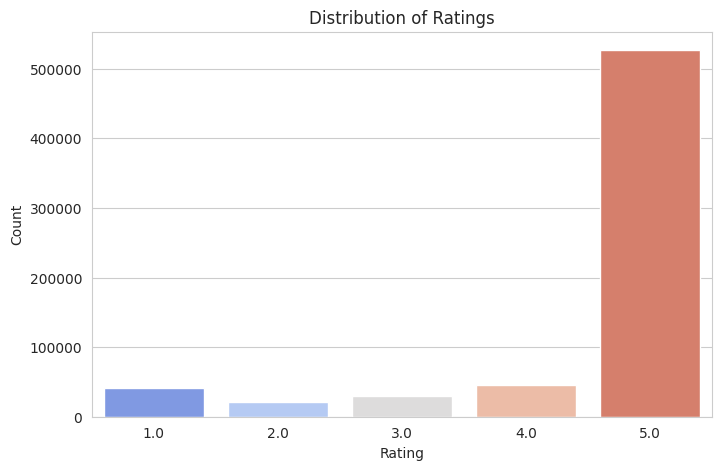

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(x="rating", data=merged_df, palette="coolwarm")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


## **Top 10 Reviewed Products**

<ipython-input-8-918de1654bbb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette="viridis")


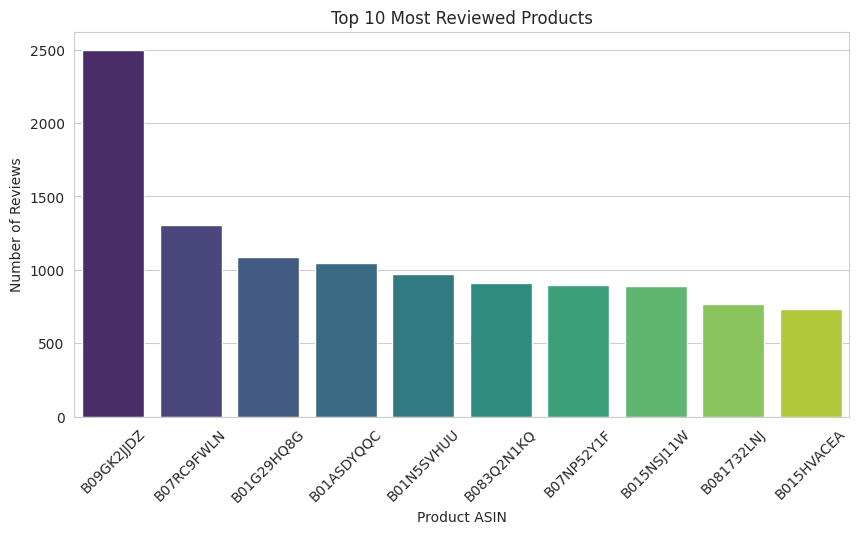

In [ ]:
top_products = merged_df["parent_asin"].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index, y=top_products.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Most Reviewed Products")
plt.xlabel("Product ASIN")
plt.ylabel("Number of Reviews")
plt.show()

## **Review Trends over Time**

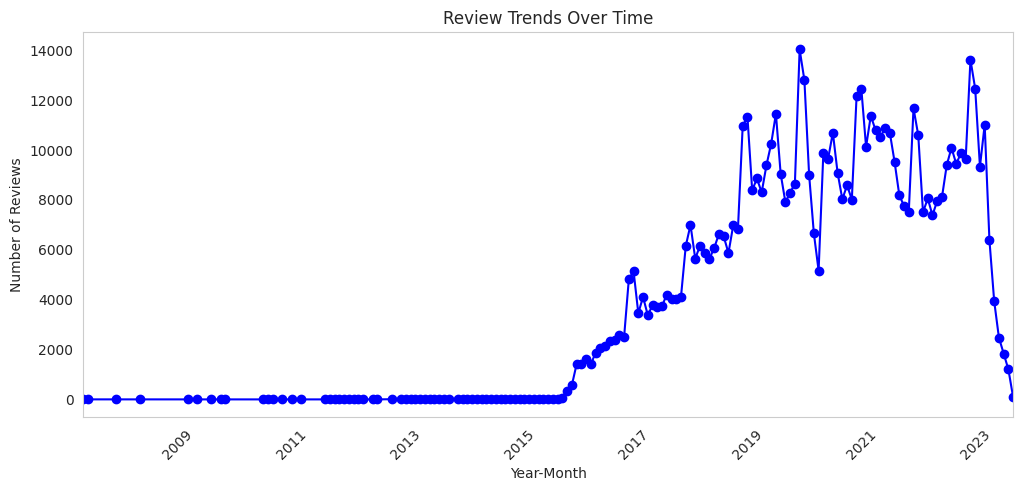

In [ ]:
merged_df["review_date"] = pd.to_datetime(merged_df["review_date"])
merged_df["year_month"] = merged_df["review_date"].dt.to_period("M")

plt.figure(figsize=(12,5))
merged_df["year_month"].value_counts().sort_index().plot(kind="line", marker="o", color="b")
plt.title("Review Trends Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.grid()
plt.show()


## **Frequent Words in Reviews**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-10-d6c3beb9e563>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Word", y="Count", data=top_words_df, palette="viridis")


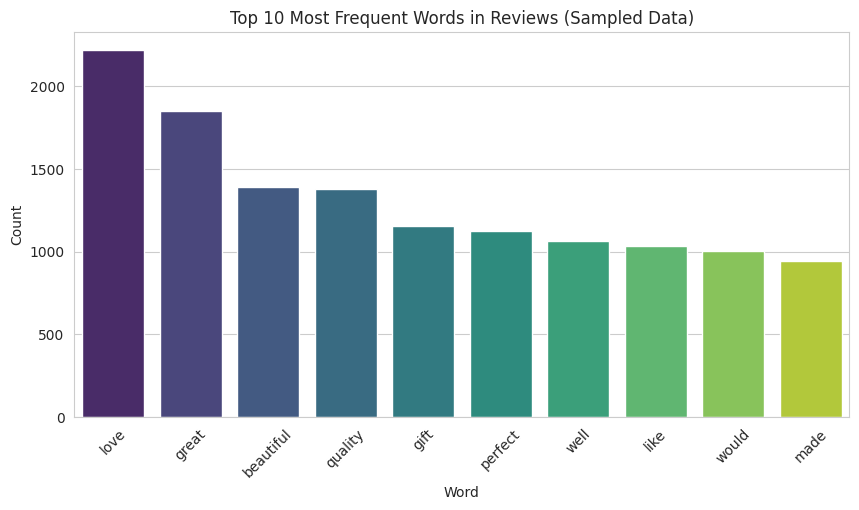

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are downloaded
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Load spaCy model for faster tokenization
nlp = spacy.load("en_core_web_sm")

# Function for optimized text processing
def preprocess_text_spacy(text):
    text = str(text).lower()
    doc = nlp(text)
    words = [token.text for token in doc if token.text.isalpha() and token.text not in stop_words]
    return words

# Sample 10,000 reviews for efficiency
sample_reviews = merged_df["text"].dropna().sample(n=10000, random_state=42)

# Apply faster processing
all_words = sample_reviews.apply(preprocess_text_spacy).sum()

# Get top 10 words
word_counts = Counter(all_words)
top_words = word_counts.most_common(10)

# Convert to DataFrame for plotting
top_words_df = pd.DataFrame(top_words, columns=["Word", "Count"])

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x="Word", y="Count", data=top_words_df, palette="viridis")
plt.title("Top 10 Most Frequent Words in Reviews (Sampled Data)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## **Word Cloud**

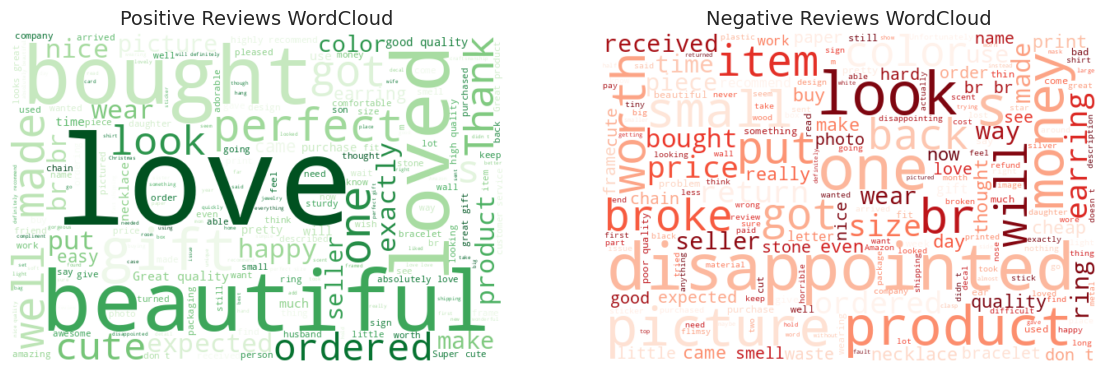

In [ ]:
# Apply Sentiment Analysis
sia = SentimentIntensityAnalyzer()
merged_df["sentiment_score"] = merged_df["text"].dropna().apply(lambda x: sia.polarity_scores(x)["compound"])

# Separate positive and negative reviews
positive_reviews = " ".join(merged_df[merged_df["sentiment_score"] > 0]["text"].dropna())
negative_reviews = " ".join(merged_df[merged_df["sentiment_score"] < 0]["text"].dropna())

# Generate WordClouds
fig, ax = plt.subplots(1, 2, figsize=(14,6))

wordcloud_pos = WordCloud(width=600, height=400, background_color="white", colormap="Greens").generate(positive_reviews)
ax[0].imshow(wordcloud_pos, interpolation="bilinear")
ax[0].set_title("Positive Reviews WordCloud", fontsize=14)
ax[0].axis("off")

wordcloud_neg = WordCloud(width=600, height=400, background_color="white", colormap="Reds").generate(negative_reviews)
ax[1].imshow(wordcloud_neg, interpolation="bilinear")
ax[1].set_title("Negative Reviews WordCloud", fontsize=14)
ax[1].axis("off")

plt.show()


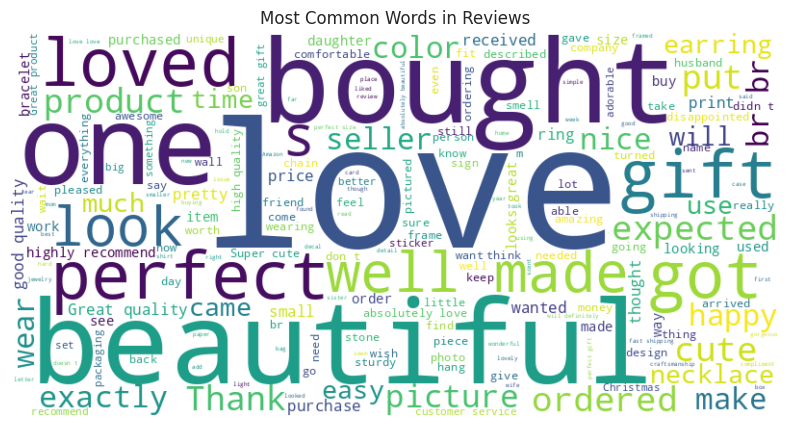

In [ ]:
all_reviews = " ".join(merged_df["text"].dropna())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_reviews)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()


## **Distribution of Review Lengths**

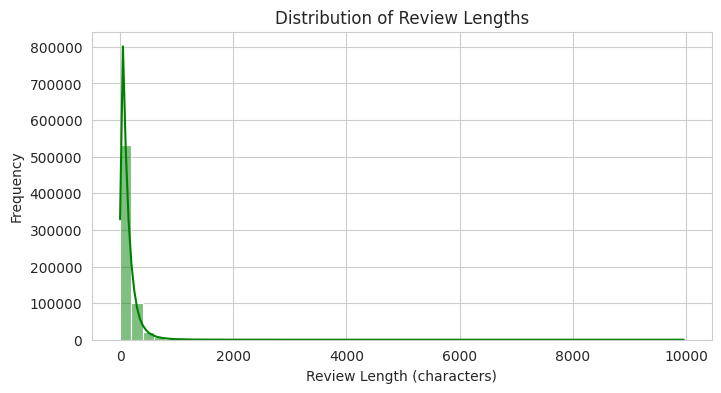

In [ ]:
merged_df["review_length"] = merged_df["text"].astype(str).apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(merged_df["review_length"], bins=50, kde=True, color="green")
plt.title("Distribution of Review Lengths")
plt.xlabel("Review Length (characters)")
plt.ylabel("Frequency")
plt.show()

## **Sentiment Distribution**

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Distribution:
sentiment_label
Positive    575037
Negative     89125
Name: count, dtype: int64


<ipython-input-17-f7ade190a694>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=merged_df["sentiment_label"], palette="viridis")


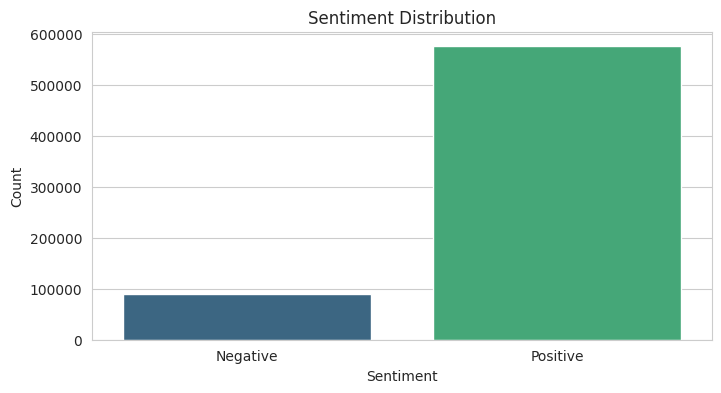

In [ ]:
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
merged_df["sentiment_score"] = merged_df["text"].astype(str).apply(lambda x: sia.polarity_scores(x)["compound"])
merged_df["sentiment_label"] = merged_df["sentiment_score"].apply(lambda x: "Positive" if x > 0 else "Negative")

print("Sentiment Distribution:")
print(merged_df["sentiment_label"].value_counts())

# Visualization
plt.figure(figsize=(8, 4))
sns.countplot(x=merged_df["sentiment_label"], palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Distribution:
sentiment_label
Positive    573554
Neutral      47277
Negative     43331
Name: count, dtype: int64


<ipython-input-18-cc8a66f513c7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=merged_df["sentiment_label"], palette="viridis", order=["Positive", "Neutral", "Negative"])


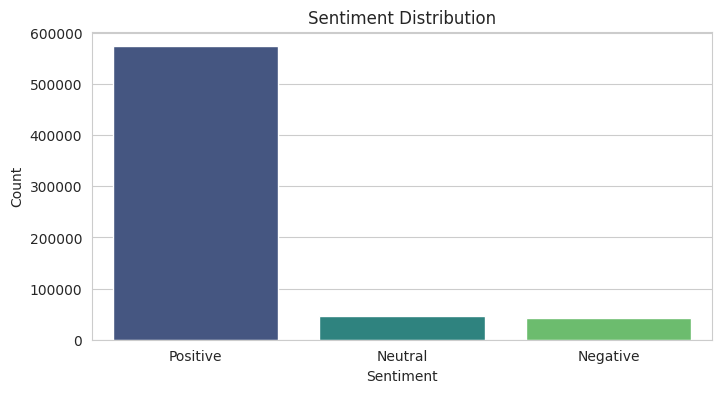

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Download and initialize VADER
nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
merged_df["sentiment_score"] = merged_df["text"].astype(str).apply(lambda x: sia.polarity_scores(x)["compound"])

# Classify sentiment
def classify_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

merged_df["sentiment_label"] = merged_df["sentiment_score"].apply(classify_sentiment)

# Display sentiment distribution
print("Sentiment Distribution:")
print(merged_df["sentiment_label"].value_counts())

# Visualization
plt.figure(figsize=(8, 4))
sns.countplot(x=merged_df["sentiment_label"], palette="viridis", order=["Positive", "Neutral", "Negative"])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [ ]:
import pandas as pd

# Load CSV files
reviews_df = pd.read_csv("/content/amazon_reviews_Handmade_Products.csv")
meta_df = pd.read_csv("/content/amazon_metadata_Handmade_Products.csv")

# Merge on 'parent_asin' to get product metadata
df = pd.merge(reviews_df, meta_df, on="parent_asin", how="left")

# Display first few rows
print(df.head())


   rating                                     title_x  \
0     5.0                            Beautiful colors   
1     5.0  You simply must order order more than one!   
2     5.0                                       Great   
3     5.0                  Well made and so beautiful   
4     5.0            Smells just like the real thing!   

                                                text  helpful_vote  \
0  I bought one for myself and one for my grandda...             1   
1  I’ve ordered three bows so far. Have not been ...             0   
2  As pictured. Used a frame from the dollar stor...             0   
3  This is beyond beautiful.  So shiny, the size ...             2   
4  Oh wow what a pleasant surprise! This smells g...             1   

  parent_asin  verified_purchase review_date main_category  \
0  B08GPJ1MSN               True  2021-05-21      Handmade   
1  B084TWHS7W               True  2020-04-24      Handmade   
2  B07V3NRQC4               True  2020-06-06      

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505183 sha256=e49634a15abbd9d90285d9ff8ca1aff7e9c94c48b3013f2191478deac928a44d
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## **Recommendation System**

In [ ]:
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load CSV files
reviews_df = pd.read_csv("/content/amazon_reviews_Handmade_Products.csv")
meta_df = pd.read_csv("/content/amazon_metadata_Handmade_Products.csv")

# Merge on 'parent_asin' to get product metadata
df = pd.merge(reviews_df, meta_df, on="parent_asin", how="left")

# Rename columns to avoid confusion
df.rename(columns={"title_x": "review_title", "title_y": "product_title"}, inplace=True)

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["parent_asin", "product_title", "rating"]], reader)

# Train-Test Split
trainset, testset = train_test_split(data, test_size=0.2)

# Train SVD Model
model = SVD()
model.fit(trainset)

# Test model
predictions = model.test(testset)
print("RMSE:", accuracy.rmse(predictions))

# Recommend items
def get_recommendations(item_id, n=5):
    item_ids = df["parent_asin"].unique()
    scores = {iid: model.predict(item_id, iid).est for iid in item_ids}
    return sorted(scores, key=scores.get, reverse=True)[:n]

print("Recommended products:", get_recommendations("B08XYZ1234"))  # Example ASIN


RMSE: 1.0949
RMSE: 1.0948830136884493
Recommended products: ['B08GPJ1MSN', 'B084TWHS7W', 'B07V3NRQC4', 'B071ZMDK26', 'B01MPVZ4YP']


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# Load CSV files
reviews_df = pd.read_csv("/content/amazon_reviews_Handmade_Products.csv")
meta_df = pd.read_csv("/content/amazon_metadata_Handmade_Products.csv")

# Merge on 'parent_asin' to get product metadata
df = pd.merge(reviews_df, meta_df, on="parent_asin", how="left")

# Rename columns to avoid confusion
df.rename(columns={"title_x": "review_title", "title_y": "product_title"}, inplace=True)

# Ensure 'text' column exists
if "text" not in df.columns:
    df["text"] = ""  # Create empty column if missing

# Combine product title & review text for content-based filtering
df["content"] = df["product_title"].fillna("") + " " + df["text"].fillna("")

# Limit data for faster testing (Optional)
df = df.sample(5000, random_state=42)  # Use a smaller sample for performance

# TF-IDF Vectorization with feature limit
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Limits to 5000 words
tfidf_matrix = vectorizer.fit_transform(df["content"])

# Use Nearest Neighbors for fast similarity search
nn = NearestNeighbors(n_neighbors=6, metric="cosine")
nn.fit(tfidf_matrix)

# Recommend similar items
def get_similar_items(item_id, n=5):
    if item_id not in df["parent_asin"].values:
        return "Item not found in dataset"

    idx = df[df["parent_asin"] == item_id].index[0]
    distances, indices = nn.kneighbors(tfidf_matrix[idx], n_neighbors=n+1)

    return df["parent_asin"].iloc[indices[0][1:]].tolist()  # Exclude the item itself

# Test recommendation function
print("Similar products:", get_similar_items("B08XYZ1234"))  # Example ASIN


Similar products: Item not found in dataset
